XG Boost
=======

Libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from scipy.stats import randint as sp_randint
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,\
                            precision_recall_fscore_support, auc, accuracy_score

from scipy import interp

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(200000)

In [3]:
data = data.reset_index()
data = data.drop("index", axis = 1)

In [4]:
data.head()

,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,disbursement_method,dti,...,sub_grade,tax_liens,term,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,verification_status,zip_code
0,AL,56244.0,Individual,54.31,54.31,54.31,1.0,0.0,Cash,13.93,...,C5,0.0,36 months,54.31,54.31,54.31,54.31,54.31,Not Verified,352xx
1,WI,72800.0,Individual,1744.00,1010.00,57.90,0.0,0.0,Cash,10.68,...,C3,0.0,36 months,1250.00,20059.00,17436.00,2400.00,2559.00,Source Verified,531xx
2,MA,60000.0,Individual,7672.00,0.00,102.60,0.0,0.0,Cash,18.02,...,E2,0.0,60 months,92.00,36011.00,30688.00,6500.00,29511.00,Source Verified,021xx
3,IN,95000.0,Individual,25618.00,2413.00,96.10,0.0,0.0,Cash,28.10,...,A5,0.0,36 months,0.00,384612.00,136091.00,61400.00,88919.00,Verified,477xx
4,IL,55000.0,Individual,2471.00,29640.00,28.70,0.0,0.0,Cash,29.97,...,B2,0.0,36 months,0.00,93866.00,39530.00,41600.00,40966.00,Not Verified,606xx


In [5]:
data.shape

(200000, 50)

Data balance:

In [6]:
data['loan_status'].value_counts()

0.0    158773
1.0     41227
Name: loan_status, dtype: int64

#### Pre-processing:

Categorical_variables:

In [7]:
categorical_variables = data.select_dtypes(include="object").columns

In [8]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [9]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [10]:
data.head()

,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,disbursement_method,dti,...,sub_grade,tax_liens,term,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,verification_status,zip_code
0,0.245231,56244.0,0.2062,54.31,54.31,54.31,1.0,0.0,0.205786,13.93,...,0.247275,0.0,0.165542,54.31,54.31,54.31,54.31,54.31,0.154584,0.256055
1,0.174326,72800.0,0.2062,1744.00,1010.00,57.90,0.0,0.0,0.205786,10.68,...,0.222872,0.0,0.165542,1250.00,20059.00,17436.00,2400.00,2559.00,0.217356,0.214854
2,0.189166,60000.0,0.2062,7672.00,0.00,102.60,0.0,0.0,0.205786,18.02,...,0.389579,0.0,0.333175,92.00,36011.00,30688.00,6500.00,29511.00,0.217356,0.163743
3,0.228460,95000.0,0.2062,25618.00,2413.00,96.10,0.0,0.0,0.205786,28.10,...,0.091321,0.0,0.165542,0.00,384612.00,136091.00,61400.00,88919.00,0.241856,0.255814
4,0.193886,55000.0,0.2062,2471.00,29640.00,28.70,0.0,0.0,0.205786,29.97,...,0.113559,0.0,0.165542,0.00,93866.00,39530.00,41600.00,40966.00,0.154584,0.169399


In [11]:
data.shape

(200000, 50)

Target:

In [12]:
X = data.loc[:, data.columns!='loan_status']
X = X.values

In [44]:
y = data['loan_status']

XG Boost:
======
__________

In [14]:
xg_boost = xgb.XGBClassifier(n_estimators=50)

Parameters to randomize:

In [15]:
xg_params = {'max_depth': [6, 10, 15, 20],
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
             'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'gamma': [0, 0.25, 0.5, 1.0],
             'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]}

Randomize search with Cross Validation:

In [28]:
random_search = RandomizedSearchCV(xg_boost, n_iter=50, param_distributions=xg_params,
                                   cv=3, scoring="roc_auc", n_jobs=2, verbose=1)

In [29]:
random_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 21.1min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed: 67.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=2,
          param_distributions={'max_depth': [6, 10, 15, 20], 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0], 'gamma': [0, 0.25, 0.5, 1.0], 'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_tr

__Cross Validation Results:__

In [34]:
pd.set_option('display.max_columns', None)
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_reg_lambda,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,23.683187,0.263514,0.500000,0.500000,0.7,0.7,0.5,0,6,5,10,0.9,"{'subsample': 0.9, 'reg_lambda': 10.0, 'min_ch...",44,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.424306,0.014176,0.000000,0.000000
1,92.345176,0.410399,0.828655,0.841638,1,1,0.5,3,15,5,50,1,"{'subsample': 1.0, 'reg_lambda': 50.0, 'min_ch...",31,0.800317,0.815757,0.863360,0.877967,0.822289,0.831191,6.507718,0.003914,0.026128,0.026450
2,68.115706,1.089619,0.925890,0.962363,0.8,0.5,0,0.2,20,3,100,0.8,"{'subsample': 0.8, 'reg_lambda': 100.0, 'min_c...",5,0.926012,0.962771,0.925996,0.961901,0.925660,0.962416,1.891701,0.109396,0.000163,0.000357
3,69.463257,2.494037,0.903902,0.999763,0.8,0.4,0.5,0.01,20,1,0.1,0.8,"{'subsample': 0.8, 'reg_lambda': 0.1, 'min_chi...",29,0.889845,0.999809,0.911058,0.999741,0.910804,0.999740,2.068644,0.112535,0.009940,0.000032
4,40.754376,1.010496,0.919469,0.962959,0.4,0.7,1,0.001,15,3,1,0.9,"{'subsample': 0.9, 'reg_lambda': 1.0, 'min_chi...",18,0.914940,0.961536,0.922308,0.963416,0.921160,0.963925,1.264905,0.086480,0.003237,0.001028
5,53.280462,0.774829,0.918169,0.944782,0.7,0.6,1,0.001,15,10,1,0.7,"{'subsample': 0.7, 'reg_lambda': 1.0, 'min_chi...",19,0.915882,0.944033,0.919733,0.944695,0.918892,0.945617,1.135136,0.023077,0.001653,0.000650
6,55.302931,0.463189,0.743693,0.758223,1,0.7,0.25,3,10,0.5,10,0.9,"{'subsample': 0.9, 'reg_lambda': 10.0, 'min_ch...",38,0.661027,0.667756,0.796817,0.815411,0.773237,0.791502,2.053858,0.049019,0.059242,0.064710
7,33.472119,0.241836,0.500000,0.500000,0.9,0.8,0.25,0,6,5,5,0.7,"{'subsample': 0.7, 'reg_lambda': 5.0, 'min_chi...",44,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.961128,0.010300,0.000000,0.000000
8,72.252373,0.981880,0.500000,0.500000,0.9,0.5,0.25,0,20,10,1,0.8,"{'subsample': 0.8, 'reg_lambda': 1.0, 'min_chi...",44,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.270581,0.041139,0.000000,0.000000
9,29.075167,0.542748,0.926288,0.940181,0.5,0.6,0,0.1,10,0.5,50,0.6,"{'subsample': 0.6, 'reg_lambda': 50.0, 'min_ch...",4,0.926144,0.940551,0.926763,0.939575,0.925958,0.940417,0.522300,0.083431,0.000344,0.000432


In [35]:
random_search.best_params_

{'colsample_bylevel': 0.7,
 'colsample_bytree': 0.5,
 'gamma': 1.0,
 'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 10.0,
 'reg_lambda': 100.0,
 'subsample': 0.9}

In [40]:
random_search.best_score_

0.9267795253839649

Feature importance:

Text(0.5,1,'Feature importance')

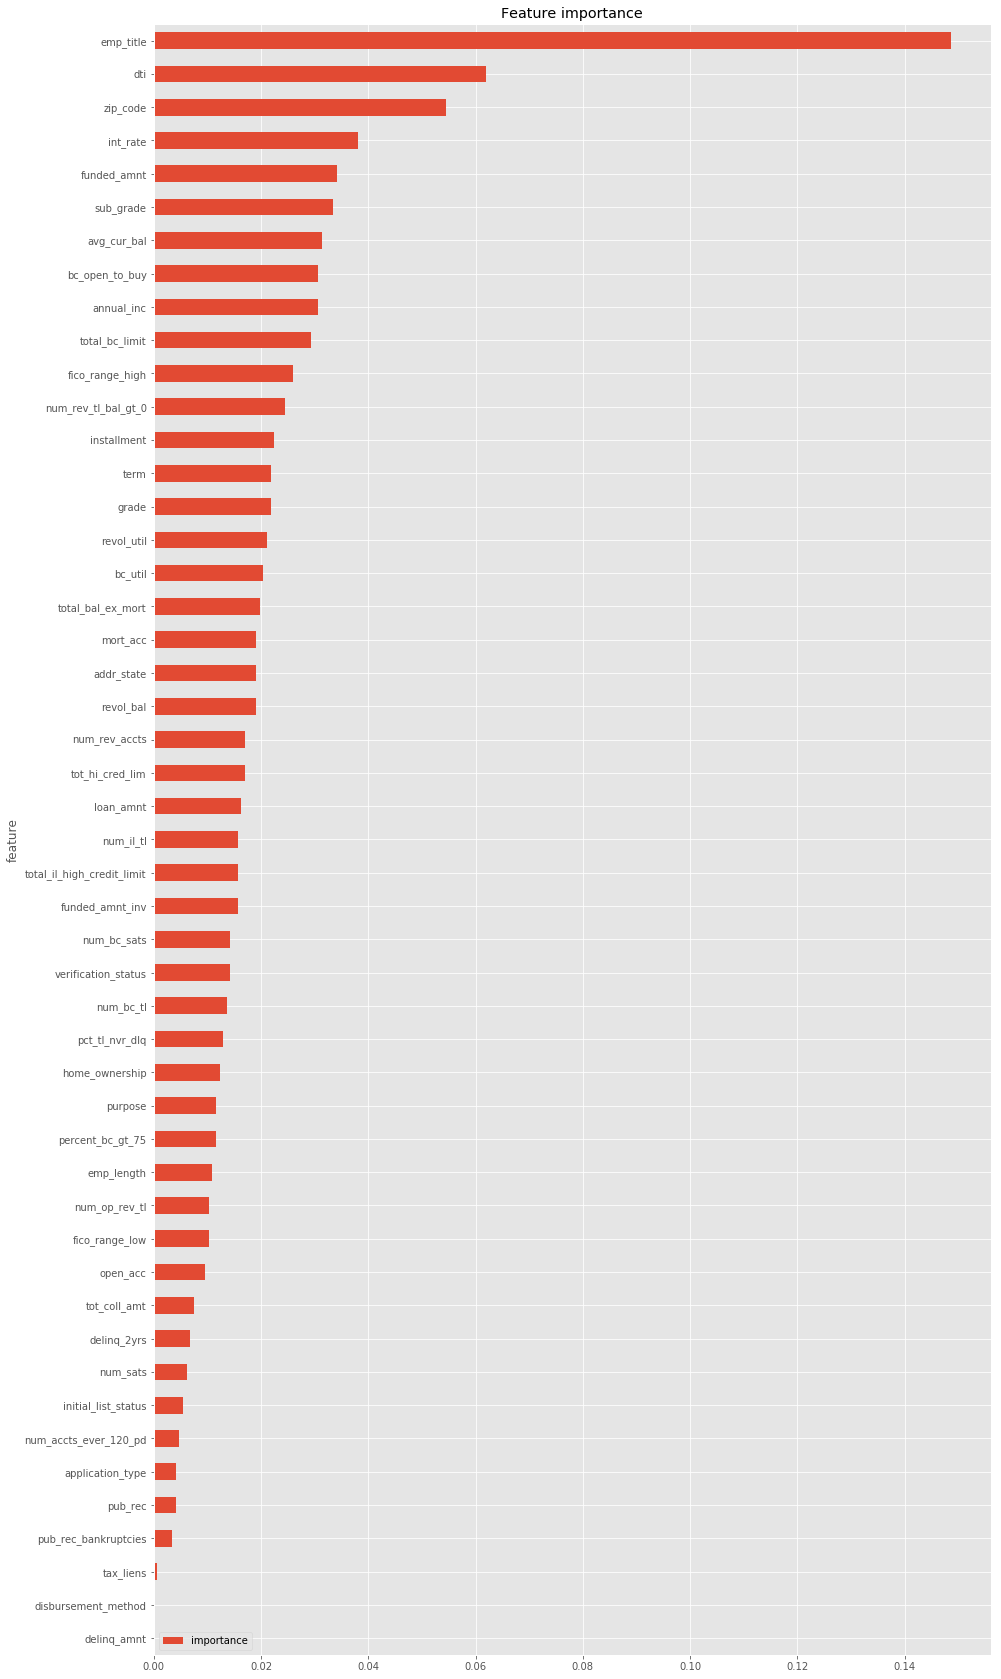

In [41]:
features = pd.DataFrame({'feature':data.loc[:, data.columns!='loan_status'].columns,
                         'importance':random_search.best_estimator_.feature_importances_})

features = features.set_index('feature').sort_values('importance', ascending=True)

features.plot(kind='barh',figsize=(15,30)).set_title('Feature importance')

In this case, `emp_title` is still the most important feature for predicting `loan_status` although with less difference with regard to random forest model. Therefore, the feature engineering made has had good performance in both models.

Model Evaluation
==========
_________________

Run classifier with cross-validation and plot __ROC curves__:

In [42]:
cv = StratifiedKFold(n_splits=5)
classifier = xgb.XGBClassifier(colsample_bylevel=0.7, colsample_bytree=0.5, gamma=1,
                               learning_rate=0.2, max_depth=6, min_child_weight=10,
                               reg_lambda=100, subsample=0.9, n_estimators=200)

In [45]:
# dataframes to numpy arrays
y = y.values

The following source code to plot ROC curves have been downloaded from [sklearn API](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) with some metrics have been added for each cross validation split:

/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

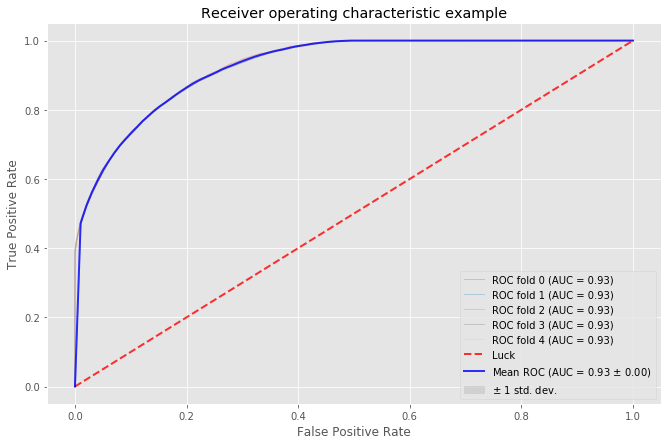

In [46]:
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(11,7))

i = 0
for train, test in cv.split(X, y):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    # accuracy
    predictions_ = classifier.predict(X[test])
    accuracy = accuracy_score(y[test], predictions_)
    accuracies.append(accuracy)
    
    # precisions
    precision = precision_recall_fscore_support(y[test], predictions_)[0][1]
    precisions.append(precision)
    
    # recall
    recall = precision_recall_fscore_support(y[test], predictions_)[1][1]
    recalls.append(recall)
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Metrics__ in the test set:

In [47]:
metrics = pd.DataFrame(
    {"auc": aucs,
     "accuracy": accuracies, 
     "precision": precisions, 
     "recall": recalls
    })

In [48]:
metrics

,accuracy,auc,precision,recall
0,0.884678,0.928085,0.833364,0.550691
1,0.885378,0.926914,0.835072,0.553238
2,0.885925,0.927535,0.825150,0.566646
3,0.886047,0.927963,0.835487,0.556822
4,0.885472,0.927352,0.830805,0.558035


In [49]:
metrics.apply(lambda i: np.mean(i), axis = 0)

accuracy     0.885500
auc          0.927570
precision    0.831976
recall       0.557087
dtype: float64